# Big Data Intelligence Assignment 2

This is the code for the Assignment 3. It uses some functions located in the utils.py file.

In [267]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils import *

## Experiments

The goal of this Assignment is to compare The two model structures to classify images from the omniglot dataset.

### Common code

In [268]:
input_size = 28 * 28 # For the omniglot dataset
num_classes = 50
seed = 1
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_loaders(num_samples_train = 15, num_samples_test = 5):
    """
    After the modifications in the image_file_to_array function of the utils, this function get images as numpy arrays
    of ones and zeros, and then provides the train and test loaders for the model.
    .
    """
    train_image, train_label, test_image, test_label = LoadData(num_classes, num_samples_train, num_samples_test, seed)
    display_images(train_image, train_label)
    train_image_tensor = torch.tensor(train_image, dtype=torch.float32)
    train_label_tensor = torch.tensor(train_label, dtype=torch.long)
    test_image_tensor = torch.tensor(test_image, dtype=torch.float32)
    test_label_tensor = torch.tensor(test_label, dtype=torch.long)

    train_dataset = TensorDataset(train_image_tensor, train_label_tensor)
    test_dataset = TensorDataset(test_image_tensor, test_label_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

def display_images(images, labels):
    """
    Plots the first 5 images in the provided dataset.
    """
    _, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axs[i].set_title(f"Label: {labels[i]}")
        axs[i].axis('off')
    plt.show()
    
def plot_history(history):
    """
    Plots the training and validation loss and accuracy.
    """
    _, axs = plt.subplots(2, 2, figsize=(15, 10))
    train_loss, train_acc = zip(*history[0])
    val_loss, val_acc = zip(*history[1])
    axs[0, 0].plot([i+1 for i in range(len(train_loss))], train_loss)
    axs[0, 0].set_title("Training Loss")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Loss")
    
    axs[0, 1].plot([i+1 for i in range(len(val_loss))], val_loss)
    axs[0, 1].set_title("Validation Loss")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    
    axs[1, 0].plot([i+1 for i in range(len(train_acc))], train_acc, color='orange')
    axs[1, 0].set_title("Training Accuracy")
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    
    axs[1, 1].plot([i+1 for i in range(len(val_acc))], val_acc, color='orange')
    axs[1, 1].set_title("Validation Accuracy")
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Accuracy")
    
    plt.show()

def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, print_every=1):
    """
    Trains the model on the provided train_loader and validates it on the test_loader.
    """
    history = [[], []]
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0 
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        verbose = epoch % print_every == 0
        history[0].append((epoch_loss, epoch_acc))
        
        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        history[1].append(evaluate(model, test_loader, criterion, verbose))

    if not verbose:
        evaluate(model, test_loader, criterion, True)
    print("Training complete!")
    return history

def evaluate(model, test_loader, criterion, verbose=True):
    """
    Evaluates the model on the provided test_loader.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total
    if verbose:
        print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return (avg_loss, accuracy)

### Fully Connected Architecture

In [269]:
class FCNN(nn.Module):
    def __init__(self, output_size, layer_sizes):
        super(FCNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, layer_sizes[0]))
        
        for i in range(1, len(layer_sizes)):
            self.layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
        
        self.output_layer = nn.Linear(layer_sizes[-1], output_size)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)

        return x

layer_sizes = [1100, 1100]
learning_rate = 0.001
fcnn_model = FCNN(num_classes, layer_sizes).to(device)
fcnn_criterion = nn.CrossEntropyLoss()
fcnn_optimizer = torch.optim.Adam(fcnn_model.parameters(), lr=learning_rate)

# Print the model architecture
summary(fcnn_model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1100]         863,500
            Linear-2              [-1, 1, 1100]       1,211,100
            Linear-3                [-1, 1, 50]          55,050
Total params: 2,129,650
Trainable params: 2,129,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 8.12
Estimated Total Size (MB): 8.14
----------------------------------------------------------------


### CNN Architecture

In [270]:
class CNN(nn.Module):
    def __init__(self, num_classes=50, use_maxpool=True, kernel_size=3):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=kernel_size, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=kernel_size, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) if use_maxpool else nn.Identity()

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, padding=0)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel_size, padding=0)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) if use_maxpool else nn.Identity()

        self.fc1 = nn.Linear(self.get_fc1_size(use_maxpool), 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.6)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def get_fc1_size(self, use_maxpool):
        if not use_maxpool:
            return 64 * 20 * 20
        return 64 * 4 * 4
    
cnn_model = CNN(num_classes).to(device)
learning_rate = 0.001
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
summary(cnn_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 32, 24, 24]           9,248
       BatchNorm2d-4           [-1, 32, 24, 24]              64
         MaxPool2d-5           [-1, 32, 12, 12]               0
            Conv2d-6           [-1, 64, 10, 10]          18,496
       BatchNorm2d-7           [-1, 64, 10, 10]             128
            Conv2d-8             [-1, 64, 8, 8]          36,928
       BatchNorm2d-9             [-1, 64, 8, 8]             128
        MaxPool2d-10             [-1, 64, 4, 4]               0
           Linear-11                  [-1, 512]         524,800
      BatchNorm1d-12                  [-1, 512]           1,024
          Dropout-13                  [-1, 512]               0
           Linear-14                   

### Training and Plotting

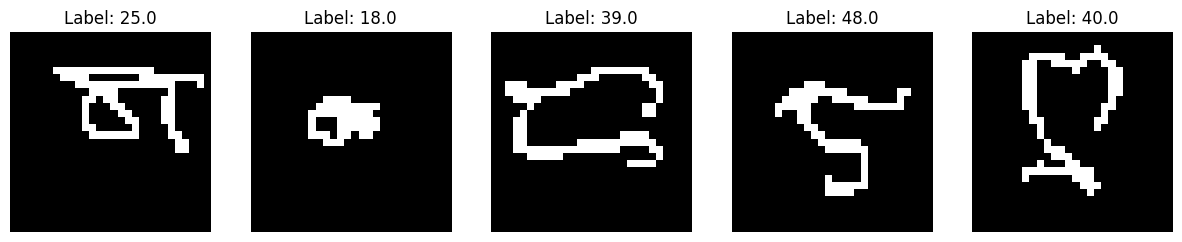

FCNN
Epoch 1/7, Loss: 3.8212, Accuracy: 0.0680
Test Loss: 3.3929, Accuracy: 0.2000
Epoch 2/7, Loss: 2.4491, Accuracy: 0.4173
Test Loss: 2.4543, Accuracy: 0.3840
Epoch 3/7, Loss: 1.2611, Accuracy: 0.6800
Test Loss: 2.1235, Accuracy: 0.4560
Epoch 4/7, Loss: 0.5874, Accuracy: 0.8587
Test Loss: 2.1282, Accuracy: 0.4800
Epoch 5/7, Loss: 0.2568, Accuracy: 0.9453
Test Loss: 2.1435, Accuracy: 0.5080
Epoch 6/7, Loss: 0.1198, Accuracy: 0.9840
Test Loss: 2.3407, Accuracy: 0.5400
Epoch 7/7, Loss: 0.0615, Accuracy: 0.9920
Test Loss: 2.3491, Accuracy: 0.5200
Training complete!


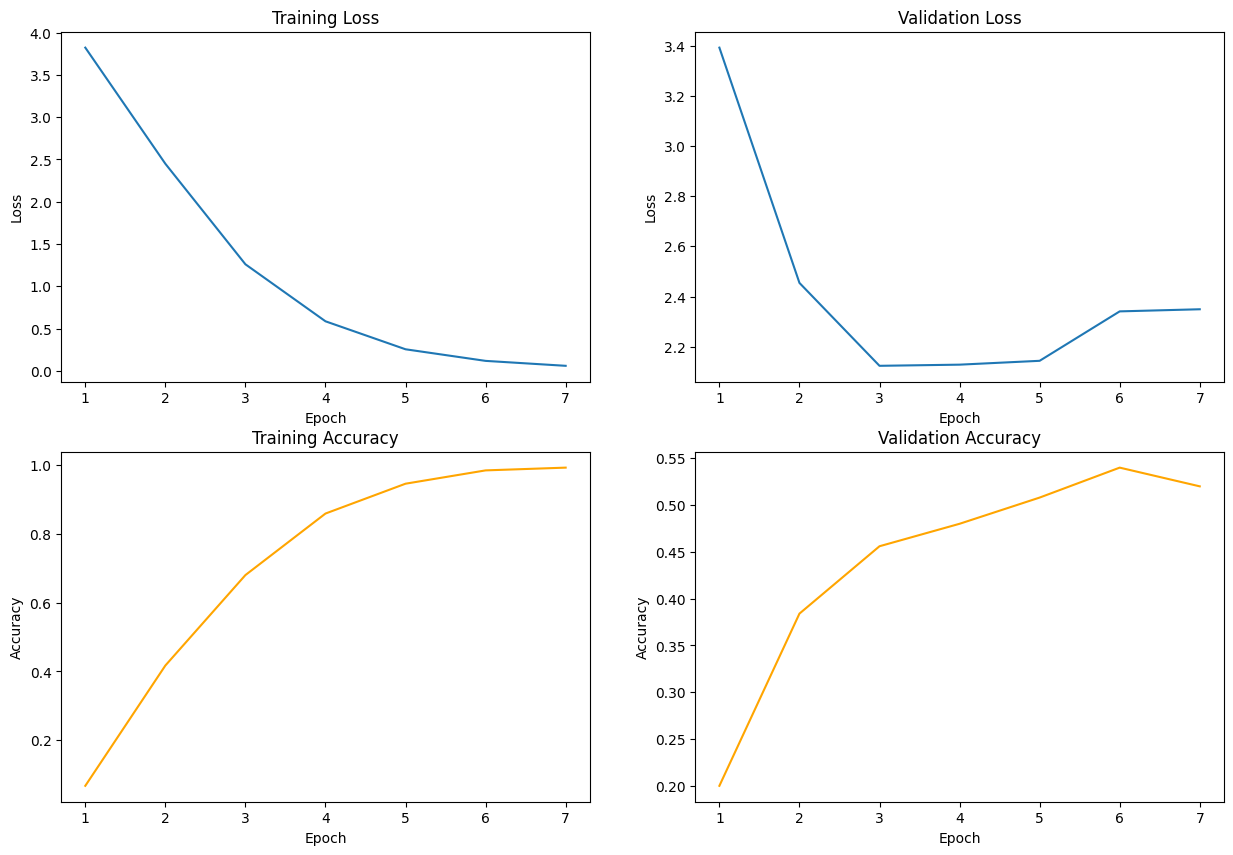

CNN
Epoch 1/30, Loss: 3.1803, Accuracy: 0.2347
Test Loss: 4.0548, Accuracy: 0.0320
Epoch 4/30, Loss: 0.5605, Accuracy: 0.9400
Test Loss: 0.9150, Accuracy: 0.8280
Epoch 7/30, Loss: 0.1617, Accuracy: 0.9933
Test Loss: 0.6851, Accuracy: 0.8400
Epoch 10/30, Loss: 0.0649, Accuracy: 0.9987
Test Loss: 0.6196, Accuracy: 0.8440
Epoch 13/30, Loss: 0.0327, Accuracy: 1.0000
Test Loss: 0.5845, Accuracy: 0.8520
Epoch 16/30, Loss: 0.0220, Accuracy: 1.0000
Test Loss: 0.5777, Accuracy: 0.8400
Epoch 19/30, Loss: 0.0136, Accuracy: 1.0000
Test Loss: 0.5648, Accuracy: 0.8520
Epoch 22/30, Loss: 0.0103, Accuracy: 1.0000
Test Loss: 0.5527, Accuracy: 0.8480
Epoch 25/30, Loss: 0.0077, Accuracy: 1.0000
Test Loss: 0.5616, Accuracy: 0.8480
Epoch 28/30, Loss: 0.0080, Accuracy: 1.0000
Test Loss: 0.5508, Accuracy: 0.8480
Test Loss: 0.5398, Accuracy: 0.8520
Training complete!


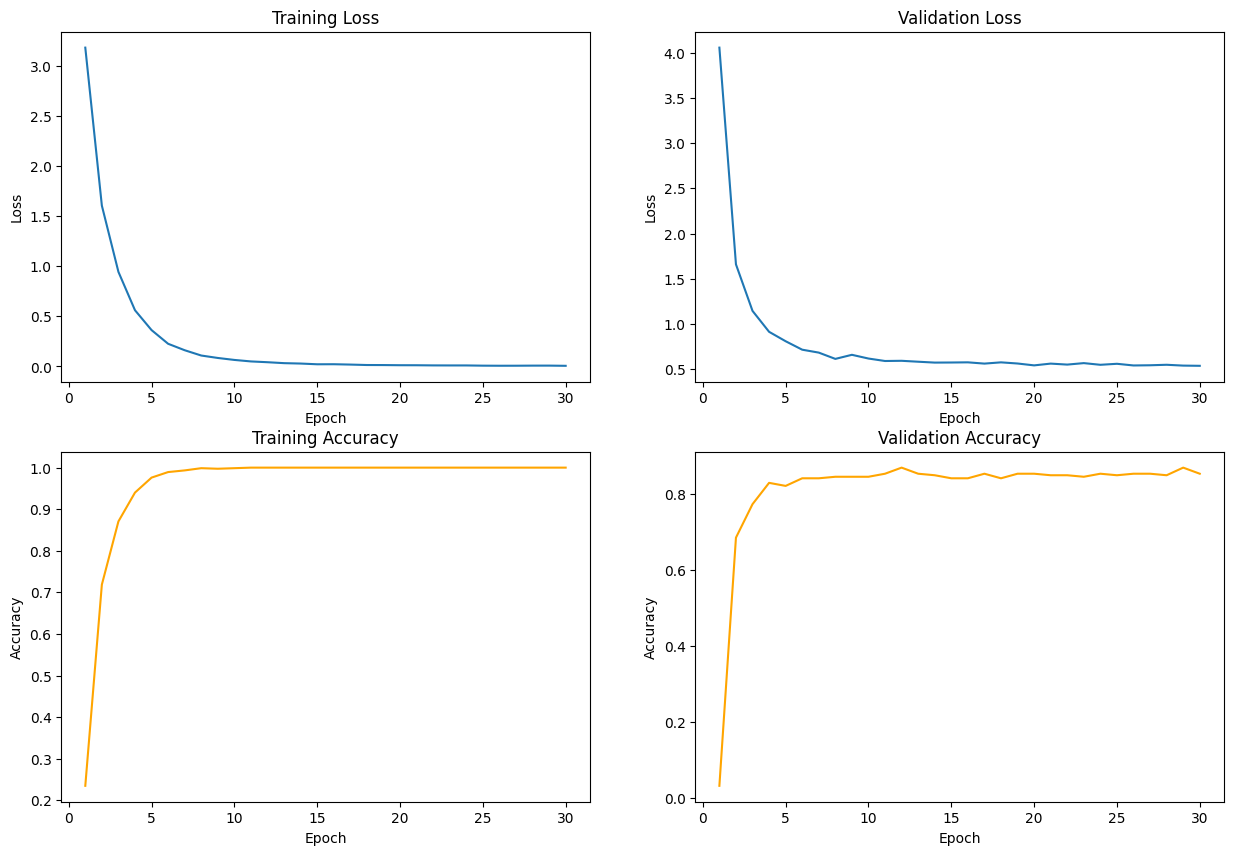

In [271]:
# training and plotting the results
train_loader, test_loader = get_loaders()
print("FCNN")
history = train(fcnn_model, train_loader, test_loader, fcnn_criterion, fcnn_optimizer, num_epochs=7, print_every=1)
plot_history(history)
print("CNN")
history = train(cnn_model, train_loader, test_loader, cnn_criterion, cnn_optimizer, num_epochs=30, print_every=3)
plot_history(history)

## Trials and Analysis

### Influence of the dataset and sampling

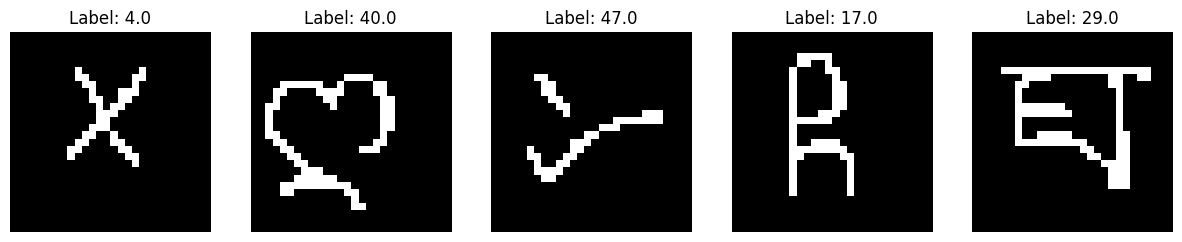

Training/Test split 10/10
Epoch 1/7, Loss: 3.5170, Accuracy: 0.1540
Test Loss: 4.1622, Accuracy: 0.0200
Epoch 7/7, Loss: 0.1844, Accuracy: 1.0000
Test Loss: 0.9610, Accuracy: 0.8140
Training complete!
Test Loss: 0.9573, Accuracy: 0.8140
Epoch 1/30, Loss: 0.1386, Accuracy: 0.9980
Test Loss: 0.9064, Accuracy: 0.8240
Epoch 30/30, Loss: 0.0057, Accuracy: 1.0000
Test Loss: 0.7001, Accuracy: 0.8320
Training complete!
Test Loss: 0.7038, Accuracy: 0.8320


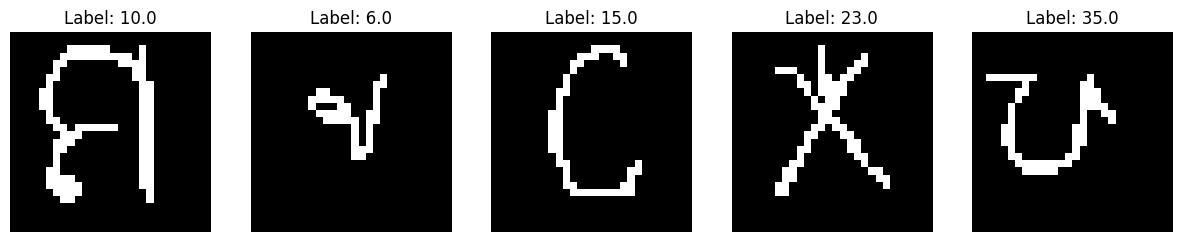

Training/Test split 11/9
Epoch 1/7, Loss: 3.4256, Accuracy: 0.1655
Test Loss: 4.2161, Accuracy: 0.0200
Epoch 7/7, Loss: 0.2367, Accuracy: 0.9836
Test Loss: 0.9422, Accuracy: 0.8222
Training complete!
Test Loss: 0.8860, Accuracy: 0.8222
Epoch 1/30, Loss: 0.1876, Accuracy: 0.9982
Test Loss: 0.7385, Accuracy: 0.8289
Epoch 30/30, Loss: 0.0690, Accuracy: 0.9927
Test Loss: 0.6271, Accuracy: 0.8467
Training complete!
Test Loss: 0.6099, Accuracy: 0.8467


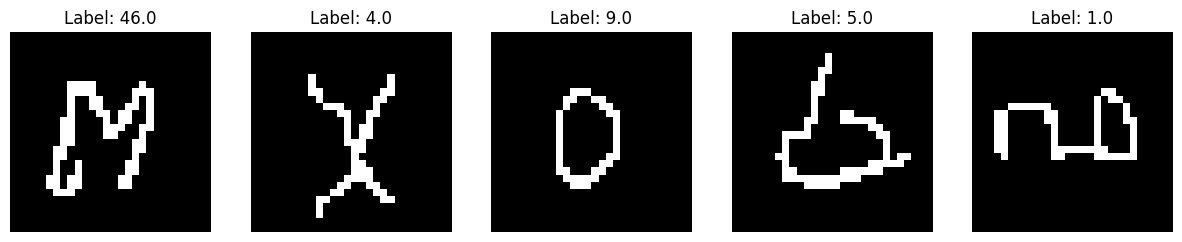

Training/Test split 12/8
Epoch 1/7, Loss: 3.3009, Accuracy: 0.2150
Test Loss: 4.4272, Accuracy: 0.0200
Epoch 7/7, Loss: 0.1522, Accuracy: 0.9967
Test Loss: 0.7941, Accuracy: 0.8375
Training complete!
Test Loss: 0.7969, Accuracy: 0.8375
Epoch 1/30, Loss: 0.1226, Accuracy: 0.9983
Test Loss: 0.7814, Accuracy: 0.8375
Epoch 30/30, Loss: 0.0048, Accuracy: 1.0000
Test Loss: 0.5878, Accuracy: 0.8450
Training complete!
Test Loss: 0.5947, Accuracy: 0.8450


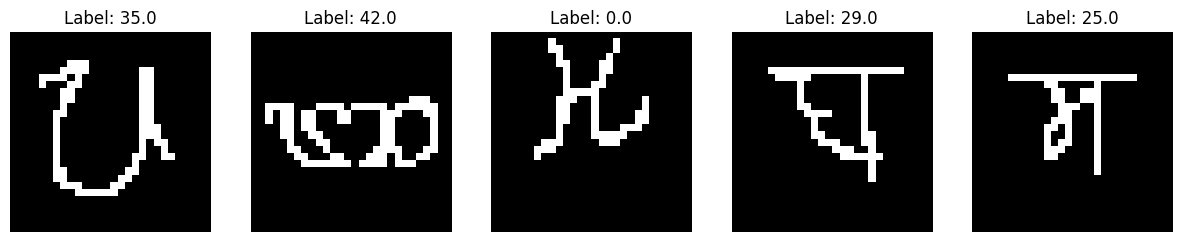

Training/Test split 13/7
Epoch 1/7, Loss: 3.2670, Accuracy: 0.2092
Test Loss: 4.0108, Accuracy: 0.0457
Epoch 7/7, Loss: 0.1795, Accuracy: 0.9938
Test Loss: 0.8062, Accuracy: 0.8029
Training complete!
Test Loss: 0.8086, Accuracy: 0.8029
Epoch 1/30, Loss: 0.1286, Accuracy: 0.9954
Test Loss: 0.7473, Accuracy: 0.8200
Epoch 30/30, Loss: 0.0043, Accuracy: 1.0000
Test Loss: 0.6086, Accuracy: 0.8343
Training complete!
Test Loss: 0.6096, Accuracy: 0.8343


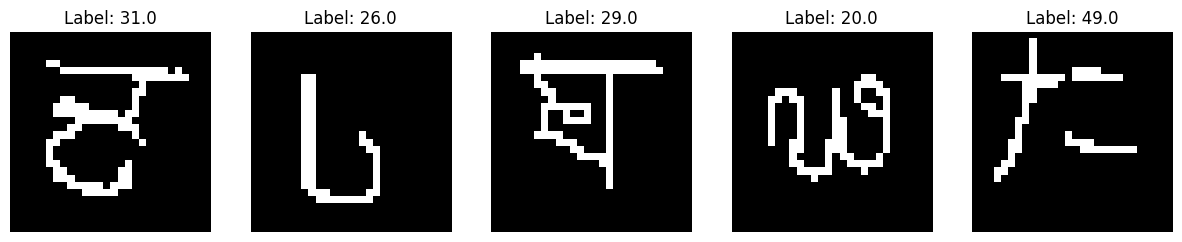

Training/Test split 14/6
Epoch 1/7, Loss: 3.2854, Accuracy: 0.2286
Test Loss: 4.2187, Accuracy: 0.0200
Epoch 7/7, Loss: 0.1521, Accuracy: 0.9957
Test Loss: 0.7798, Accuracy: 0.8167
Training complete!
Test Loss: 0.7776, Accuracy: 0.8167
Epoch 1/30, Loss: 0.1026, Accuracy: 0.9971
Test Loss: 0.7133, Accuracy: 0.8267
Epoch 30/30, Loss: 0.0038, Accuracy: 1.0000
Test Loss: 0.5888, Accuracy: 0.8467
Training complete!
Test Loss: 0.5349, Accuracy: 0.8467


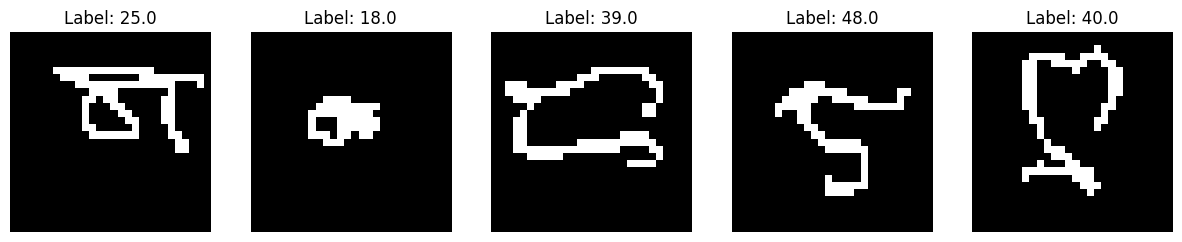

Training/Test split 15/5
Epoch 1/7, Loss: 3.2401, Accuracy: 0.2173
Test Loss: 4.7248, Accuracy: 0.0200
Epoch 7/7, Loss: 0.1267, Accuracy: 0.9973
Test Loss: 0.6591, Accuracy: 0.8440
Training complete!
Test Loss: 0.6669, Accuracy: 0.8440
Epoch 1/30, Loss: 0.0819, Accuracy: 1.0000
Test Loss: 0.6505, Accuracy: 0.8440
Epoch 30/30, Loss: 0.0035, Accuracy: 1.0000
Test Loss: 0.5057, Accuracy: 0.8560
Training complete!
Test Loss: 0.5111, Accuracy: 0.8560


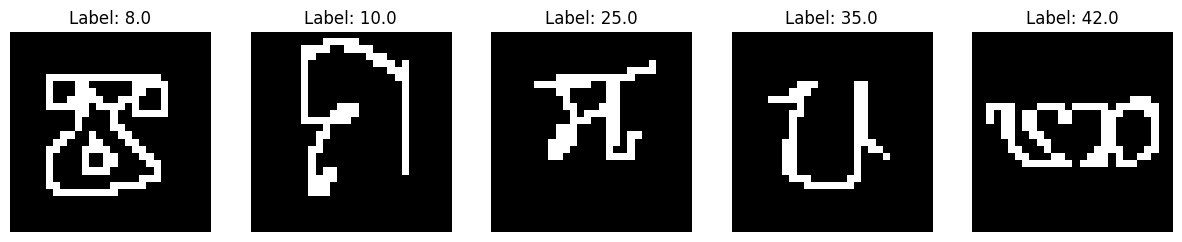

Training/Test split 16/4
Epoch 1/7, Loss: 3.1426, Accuracy: 0.2487
Test Loss: 3.7279, Accuracy: 0.0350
Epoch 7/7, Loss: 0.1275, Accuracy: 0.9975
Test Loss: 0.6153, Accuracy: 0.8700
Training complete!
Test Loss: 0.5989, Accuracy: 0.8700
Epoch 1/30, Loss: 0.0865, Accuracy: 1.0000
Test Loss: 0.5919, Accuracy: 0.8550
Epoch 30/30, Loss: 0.0034, Accuracy: 1.0000
Test Loss: 0.4349, Accuracy: 0.8750
Training complete!
Test Loss: 0.3941, Accuracy: 0.8750


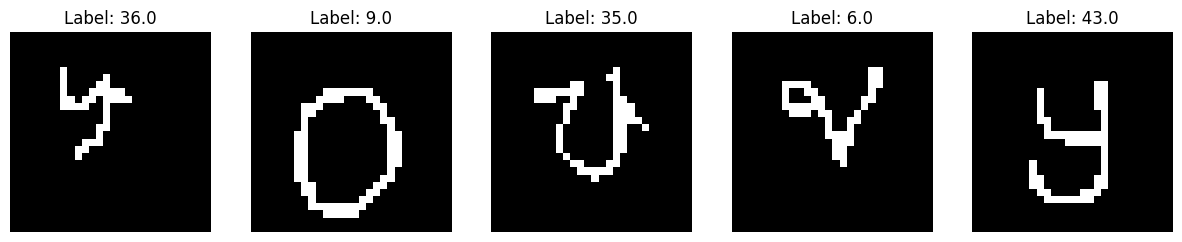

Training/Test split 17/3
Epoch 1/7, Loss: 3.1481, Accuracy: 0.2424
Test Loss: 4.1343, Accuracy: 0.0267
Epoch 7/7, Loss: 0.1302, Accuracy: 0.9965
Test Loss: 0.5724, Accuracy: 0.8533
Training complete!
Test Loss: 0.5948, Accuracy: 0.8533
Epoch 1/30, Loss: 0.1080, Accuracy: 0.9929
Test Loss: 0.6079, Accuracy: 0.8533
Epoch 30/30, Loss: 0.0034, Accuracy: 1.0000
Test Loss: 0.4864, Accuracy: 0.8600
Training complete!
Test Loss: 0.4914, Accuracy: 0.8600


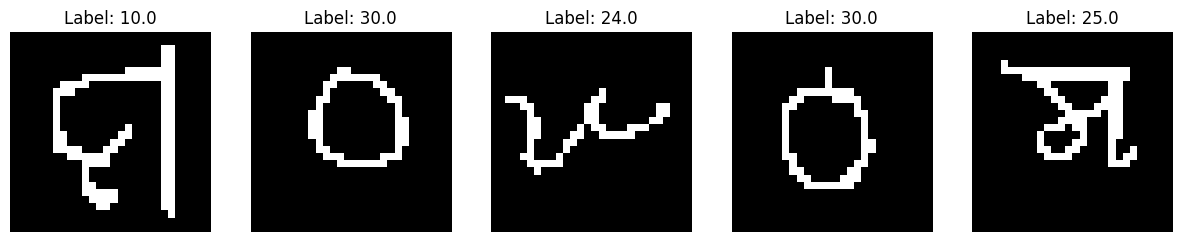

Training/Test split 18/2
Epoch 1/7, Loss: 3.1446, Accuracy: 0.2356
Test Loss: 3.1872, Accuracy: 0.1100
Epoch 7/7, Loss: 0.2423, Accuracy: 0.9767
Test Loss: 0.5727, Accuracy: 0.8500
Training complete!
Test Loss: 0.6595, Accuracy: 0.8500
Epoch 1/30, Loss: 0.1938, Accuracy: 0.9856
Test Loss: 0.5851, Accuracy: 0.9200
Epoch 30/30, Loss: 0.0491, Accuracy: 0.9922
Test Loss: 0.3590, Accuracy: 0.8800
Training complete!
Test Loss: 0.3346, Accuracy: 0.8800


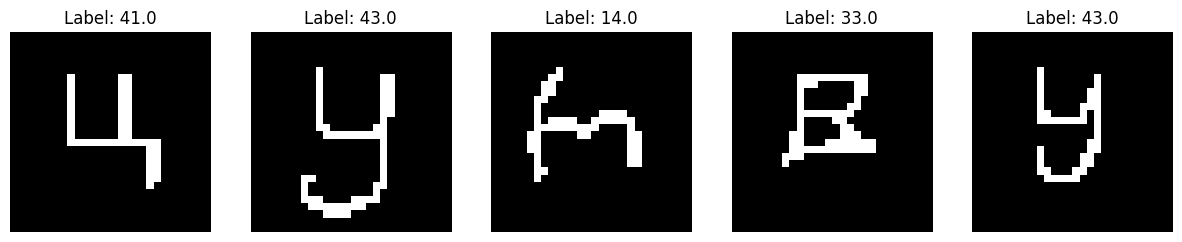

Training/Test split 19/1
Epoch 1/7, Loss: 3.0230, Accuracy: 0.2853
Test Loss: 3.4879, Accuracy: 0.0800
Epoch 7/7, Loss: 0.1263, Accuracy: 0.9958
Test Loss: 0.4847, Accuracy: 0.8800
Training complete!
Test Loss: 0.4311, Accuracy: 0.8800
Epoch 1/30, Loss: 0.0910, Accuracy: 0.9947
Test Loss: 0.4392, Accuracy: 0.9000
Epoch 30/30, Loss: 0.0033, Accuracy: 1.0000
Test Loss: 0.3000, Accuracy: 0.9000
Training complete!
Test Loss: 0.2972, Accuracy: 0.9000
Final accuracies:
[0.814, 0.8222222222222222, 0.8375, 0.8028571428571428, 0.8166666666666667, 0.844, 0.87, 0.8533333333333334, 0.85, 0.88]
[0.832, 0.8466666666666667, 0.845, 0.8342857142857143, 0.8466666666666667, 0.856, 0.875, 0.86, 0.88, 0.9]


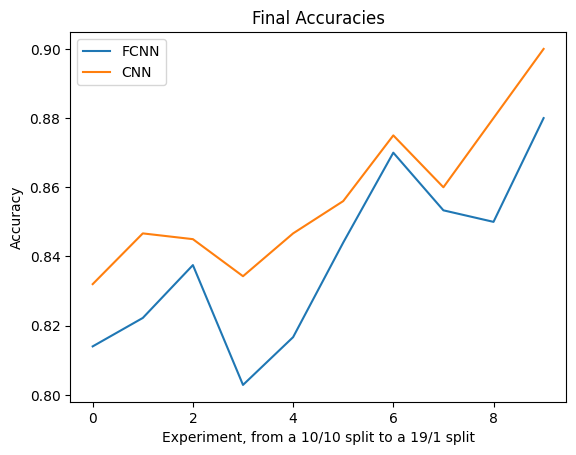

In [272]:
final_accuracies = [[],[]]

for i in range(5, 0, -1):
    
    learning_rate = 0.001
    test_cnn = FCNN(num_classes, [1100, 1100]).to(device)
    test_cnn_criterion = nn.CrossEntropyLoss()
    test_cnn_optimizer = torch.optim.Adam(test_cnn.parameters(), lr=learning_rate)
    
    test_cnn = CNN(num_classes).to(device)
    test_cnn_criterion = nn.CrossEntropyLoss()
    test_cnn_optimizer = torch.optim.Adam(test_cnn.parameters(), lr=learning_rate)
    
    train_loader, test_loader = get_loaders(15-i, 5+i)
    
    print(f"Training/Test split {15-i}/{5+i}")
    train(test_cnn, train_loader, test_loader, test_cnn_criterion, test_cnn_optimizer, num_epochs=7, print_every=6)
    final_accuracies[0].append(evaluate(test_cnn, test_loader, test_cnn_criterion, True)[1])
    train(test_cnn, train_loader, test_loader, test_cnn_criterion, test_cnn_optimizer, num_epochs=30, print_every=29)
    final_accuracies[1].append(evaluate(test_cnn, test_loader, test_cnn_criterion, True)[1])
    
for i in range(5):
    
    learning_rate = 0.001
    test_cnn = FCNN(num_classes, [1100, 1100]).to(device)
    test_cnn_criterion = nn.CrossEntropyLoss()
    test_cnn_optimizer = torch.optim.Adam(test_cnn.parameters(), lr=learning_rate)
    
    test_cnn = CNN(num_classes).to(device)
    test_cnn_criterion = nn.CrossEntropyLoss()
    test_cnn_optimizer = torch.optim.Adam(test_cnn.parameters(), lr=learning_rate)
    
    train_loader, test_loader = get_loaders(15+i, 5-i)
    
    print(f"Training/Test split {15+i}/{5-i}")
    train(test_cnn, train_loader, test_loader, test_cnn_criterion, test_cnn_optimizer, num_epochs=7, print_every=6)
    final_accuracies[0].append(evaluate(test_cnn, test_loader, test_cnn_criterion, True)[1])
    train(test_cnn, train_loader, test_loader, test_cnn_criterion, test_cnn_optimizer, num_epochs=30, print_every=29)
    final_accuracies[1].append(evaluate(test_cnn, test_loader, test_cnn_criterion, True)[1])

# plot the final accuracies    
print("Final accuracies:")
print(final_accuracies[0])
print(final_accuracies[1])
plt.plot(final_accuracies[0], label="FCNN")
plt.plot(final_accuracies[1], label="CNN")
plt.title("Final Accuracies")
plt.xlabel("Experiment, from a 10/10 split to a 19/1 split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Influence of the model architecture

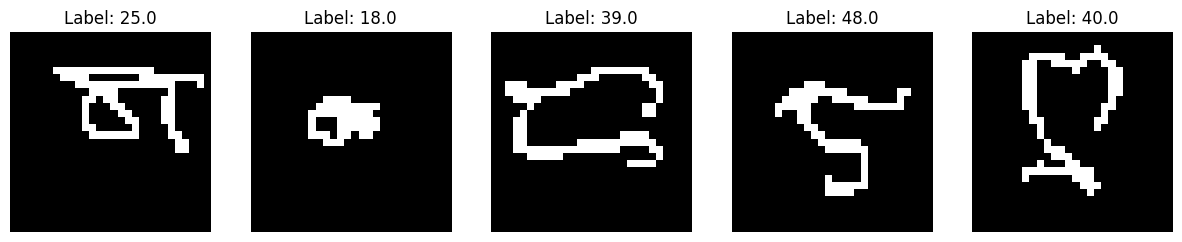

Training FCNN with architecture [1100]
Epoch 1/10, Loss: 3.7615, Accuracy: 0.1133
Test Loss: 3.4273, Accuracy: 0.2960
Epoch 10/10, Loss: 0.0576, Accuracy: 1.0000
Test Loss: 2.0831, Accuracy: 0.5160
Training complete!
Test Loss: 2.0948, Accuracy: 0.5160


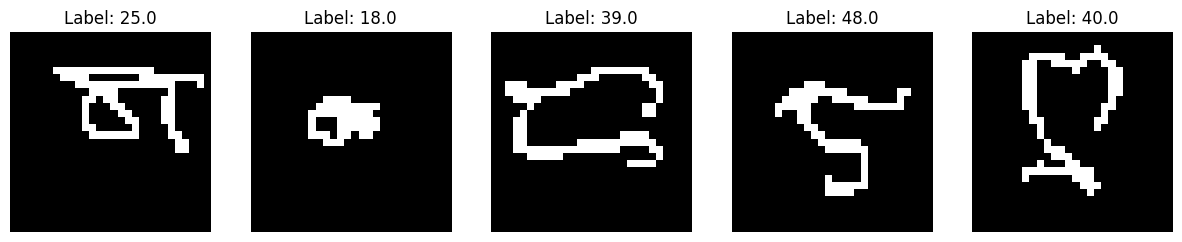

Training FCNN with architecture [1100, 1100]
Epoch 1/10, Loss: 3.8168, Accuracy: 0.0760
Test Loss: 3.4174, Accuracy: 0.2560
Epoch 10/10, Loss: 0.0077, Accuracy: 1.0000
Test Loss: 2.4157, Accuracy: 0.5480
Training complete!
Test Loss: 2.3844, Accuracy: 0.5480


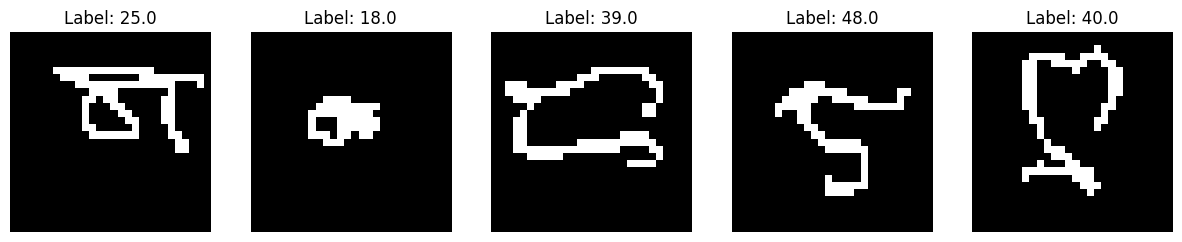

Training FCNN with architecture [1100, 1100, 1100]
Epoch 1/10, Loss: 3.8723, Accuracy: 0.0373
Test Loss: 3.5696, Accuracy: 0.1280
Epoch 10/10, Loss: 0.0332, Accuracy: 0.9947
Test Loss: 3.4487, Accuracy: 0.4760
Training complete!
Test Loss: 3.4246, Accuracy: 0.4760


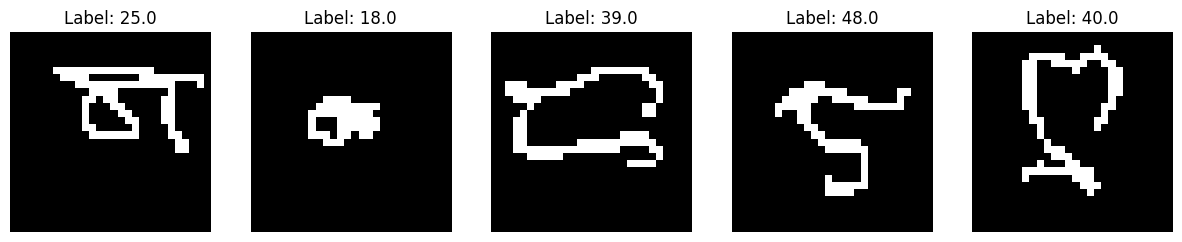

Training FCNN with architecture [1100, 1100, 1100, 1100]
Epoch 1/10, Loss: 3.8914, Accuracy: 0.0280
Test Loss: 3.7041, Accuracy: 0.0640
Epoch 10/10, Loss: 0.3071, Accuracy: 0.9067
Test Loss: 3.8184, Accuracy: 0.3880
Training complete!
Test Loss: 3.8340, Accuracy: 0.3880


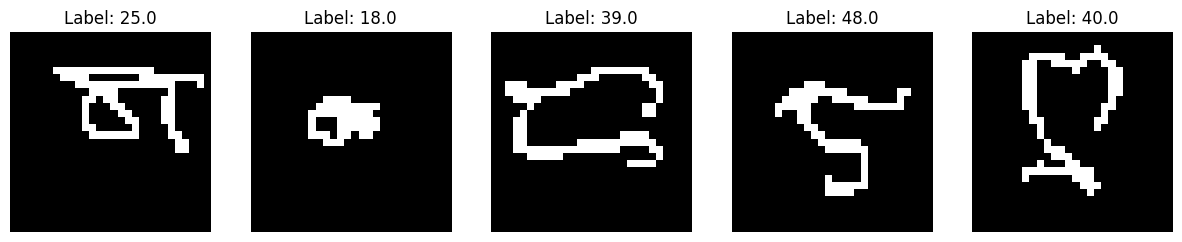

Training FCNN with architecture [1100, 1100, 1100, 1100, 1100]
Epoch 1/10, Loss: 3.9133, Accuracy: 0.0160
Test Loss: 3.8058, Accuracy: 0.0240
Epoch 10/10, Loss: 1.9329, Accuracy: 0.2587
Test Loss: 3.6047, Accuracy: 0.1560
Training complete!
Test Loss: 3.6128, Accuracy: 0.1560
Final accuracies:
[0.516, 0.548, 0.476, 0.388, 0.156]
[1.0, 1.0, 0.9946666666666667, 0.9066666666666666, 0.25866666666666666]


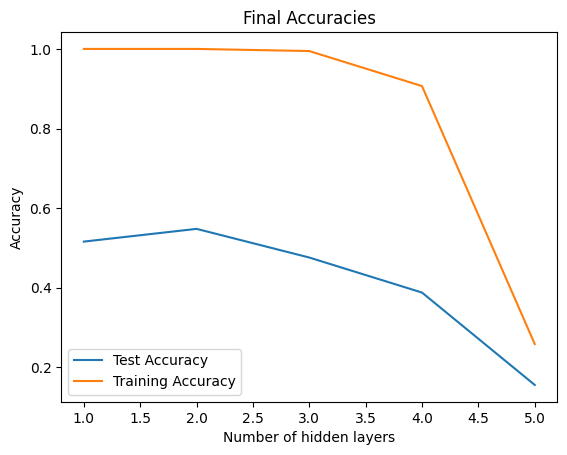

In [273]:
fcnn_architectures = [[1100], [1100, 1100], [1100, 1100, 1100], [1100, 1100, 1100, 1100], [1100, 1100, 1100, 1100, 1100]]
final_accuracies = [[],[]]
for arch in fcnn_architectures:
    learning_rate = 0.001
    test_cnn = FCNN(num_classes, arch).to(device)
    test_cnn_criterion = nn.CrossEntropyLoss()
    test_cnn_optimizer = torch.optim.Adam(test_cnn.parameters(), lr=learning_rate)
    
    train_loader, test_loader = get_loaders()
    
    print(f"Training FCNN with architecture {arch}")
    history = train(test_cnn, train_loader, test_loader, test_cnn_criterion, test_cnn_optimizer, num_epochs=10, print_every=9)
    final_accuracies[0].append(evaluate(test_cnn, test_loader, test_cnn_criterion, True)[1])
    final_accuracies[1].append(history[0][-1][1])
    
# plot the final accuracies    
print("Final accuracies:")
print(final_accuracies[0])
print(final_accuracies[1])
plt.plot([i+1 for i in range(len(final_accuracies[0]))], final_accuracies[0], label="Test Accuracy")
plt.plot([i+1 for i in range(len(final_accuracies[1]))], final_accuracies[1], label="Training Accuracy")
plt.title("Final Accuracies")
plt.xlabel("Number of hidden layers")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 32, 24, 24]           9,248
       BatchNorm2d-4           [-1, 32, 24, 24]              64
         MaxPool2d-5           [-1, 32, 12, 12]               0
            Conv2d-6           [-1, 64, 10, 10]          18,496
       BatchNorm2d-7           [-1, 64, 10, 10]             128
            Conv2d-8             [-1, 64, 8, 8]          36,928
       BatchNorm2d-9             [-1, 64, 8, 8]             128
        MaxPool2d-10             [-1, 64, 4, 4]               0
           Linear-11                  [-1, 512]         524,800
      BatchNorm1d-12                  [-1, 512]           1,024
          Dropout-13                  [-1, 512]               0
           Linear-14                   

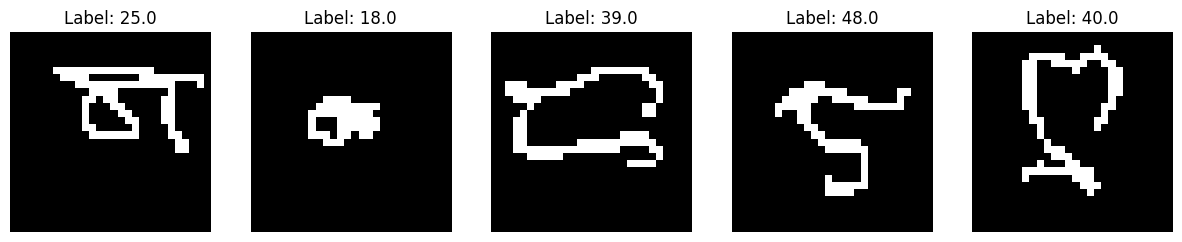

CNN with max pooling
Epoch 1/30, Loss: 3.2626, Accuracy: 0.2160
Test Loss: 4.4019, Accuracy: 0.0360
Epoch 30/30, Loss: 0.0054, Accuracy: 1.0000
Test Loss: 0.5757, Accuracy: 0.8520
Training complete!
Training took 31.07 seconds
Final accuracy: 0.8520


CNN without max pooling
Epoch 1/30, Loss: 3.0807, Accuracy: 0.2547
Test Loss: 3.8150, Accuracy: 0.0480
Epoch 30/30, Loss: 0.0027, Accuracy: 1.0000
Test Loss: 0.8427, Accuracy: 0.7920
Training complete!
Training took 124.57 seconds
Final accuracy: 0.7920


In [274]:
import time

test_cnn = CNN(num_classes).to(device)
test_cnn_criterion = nn.CrossEntropyLoss()
test_cnn_optimizer = torch.optim.Adam(test_cnn.parameters(), lr=0.001)

test_cnn_no_pool = CNN(num_classes, use_maxpool=False).to(device)
test_cnn_no_pool_criterion = nn.CrossEntropyLoss()
test_cnn_no_pool_optimizer = torch.optim.Adam(test_cnn_no_pool.parameters(), lr=0.001)

summary(test_cnn, input_size=(1, 28, 28))
summary(test_cnn_no_pool, input_size=(1, 28, 28))

train_loader, test_loader = get_loaders()

print("CNN with max pooling")
t0 = time.time()
history = train(test_cnn, train_loader, test_loader, test_cnn_criterion, test_cnn_optimizer, num_epochs=30, print_every=29)
t1 = time.time() - t0
print(f"Training took {t1:.2f} seconds")
_, acc = evaluate(test_cnn, test_loader, test_cnn_criterion, False)
print(f"Final accuracy: {acc:.4f}")

print("\n")
print("CNN without max pooling")
t0 = time.time()
history = train(test_cnn_no_pool, train_loader, test_loader, test_cnn_no_pool_criterion, test_cnn_no_pool_optimizer, num_epochs=30, print_every=29)
t1 = time.time() - t0
print(f"Training took {t1:.2f} seconds")
_, acc = evaluate(test_cnn_no_pool, test_loader, test_cnn_no_pool_criterion, False)
print(f"Final accuracy: {acc:.4f}")

### Influence of hyperparameters

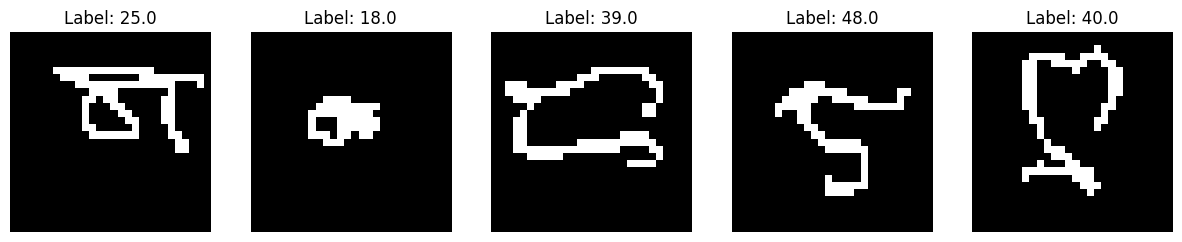

Training FCNN with optimizer <class 'torch.optim.adam.Adam'>
Epoch 1/10, Loss: 3.8027, Accuracy: 0.0680
Test Loss: 3.3811, Accuracy: 0.2360
Epoch 10/10, Loss: 0.0080, Accuracy: 1.0000
Test Loss: 2.5489, Accuracy: 0.5400
Training complete!
Test Loss: 2.4671, Accuracy: 0.5400
Training FCNN with optimizer <class 'torch.optim.sgd.SGD'>
Epoch 1/10, Loss: 3.9122, Accuracy: 0.0240
Test Loss: 3.9135, Accuracy: 0.0040
Epoch 10/10, Loss: 3.9100, Accuracy: 0.0267
Test Loss: 3.9122, Accuracy: 0.0040
Training complete!
Test Loss: 3.9120, Accuracy: 0.0040
Training FCNN with optimizer <class 'torch.optim.rmsprop.RMSprop'>
Epoch 1/10, Loss: 3.7894, Accuracy: 0.0720
Test Loss: 3.0690, Accuracy: 0.2160
Epoch 10/10, Loss: 0.0043, Accuracy: 1.0000
Test Loss: 2.2167, Accuracy: 0.5480
Training complete!
Test Loss: 2.2174, Accuracy: 0.5480
Final accuracies:
[0.54, 0.004, 0.548]


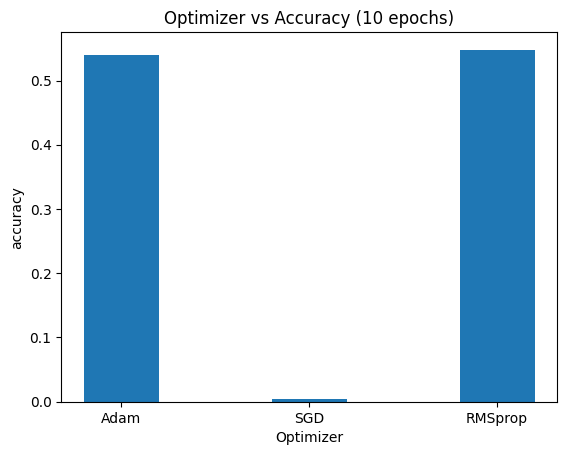

In [275]:
optimizers = [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop]
train_loader, test_loader = get_loaders()
final_accuracies = []
for opt in optimizers:
    test_cnn = FCNN(num_classes, [1100, 1100]).to(device)
    test_cnn_criterion = nn.CrossEntropyLoss()
    test_cnn_optimizer = opt(test_cnn.parameters(), lr=0.001)
    
    print(f"Training FCNN with optimizer {opt}")
    history = train(test_cnn, train_loader, test_loader, test_cnn_criterion, test_cnn_optimizer, num_epochs=10, print_every=9)
    final_accuracies.append(evaluate(test_cnn, test_loader, test_cnn_criterion, True)[1])

# plot the final accuracies   
print("Final accuracies:")
print(final_accuracies)
plt.bar([str(el).split(".")[-1][:-2] for el in optimizers], final_accuracies, width=0.4)
plt.xlabel("Optimizer")
plt.ylabel("accuracy")
plt.title("Optimizer vs Accuracy (10 epochs)")
plt.show()

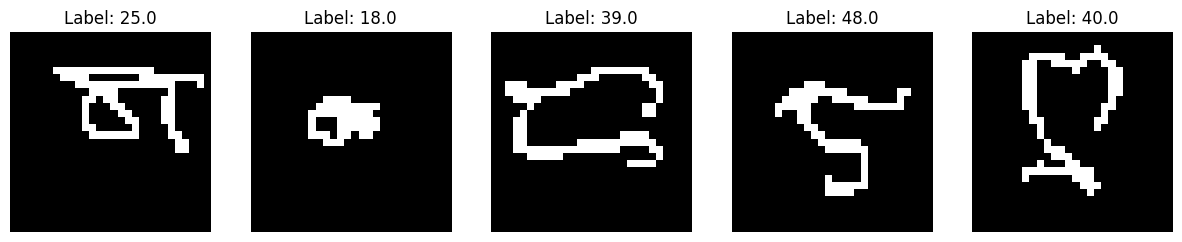

Epoch 1/30, Loss: 59.6076, Accuracy: 0.0320
Test Loss: 6540.7682, Accuracy: 0.0280
Epoch 30/30, Loss: 4.9475, Accuracy: 0.0200
Test Loss: 57.9726, Accuracy: 0.0160
Training complete!
Test Loss: 58.5259, Accuracy: 0.0160
Epoch 1/30, Loss: 7.0066, Accuracy: 0.0947
Test Loss: 9.1733, Accuracy: 0.1360


Epoch 30/30, Loss: 2.4875, Accuracy: 0.2880
Test Loss: 1.4384, Accuracy: 0.5960
Training complete!
Test Loss: 1.4364, Accuracy: 0.5960
Epoch 1/30, Loss: 3.2608, Accuracy: 0.2453
Test Loss: 2.2912, Accuracy: 0.4040
Epoch 30/30, Loss: 0.1086, Accuracy: 0.9693
Test Loss: 0.8694, Accuracy: 0.8160
Training complete!
Test Loss: 0.8567, Accuracy: 0.8160
Epoch 1/30, Loss: 3.2814, Accuracy: 0.2093
Test Loss: 4.4868, Accuracy: 0.0200
Epoch 30/30, Loss: 0.0061, Accuracy: 1.0000
Test Loss: 0.5847, Accuracy: 0.8480
Training complete!
Test Loss: 0.5803, Accuracy: 0.8480
Epoch 1/30, Loss: 3.9600, Accuracy: 0.0413
Test Loss: 3.9331, Accuracy: 0.0280
Epoch 30/30, Loss: 0.2399, Accuracy: 0.9987
Test Loss: 1.2495, Accuracy: 0.7800
Training complete!
Test Loss: 1.2498, Accuracy: 0.7800


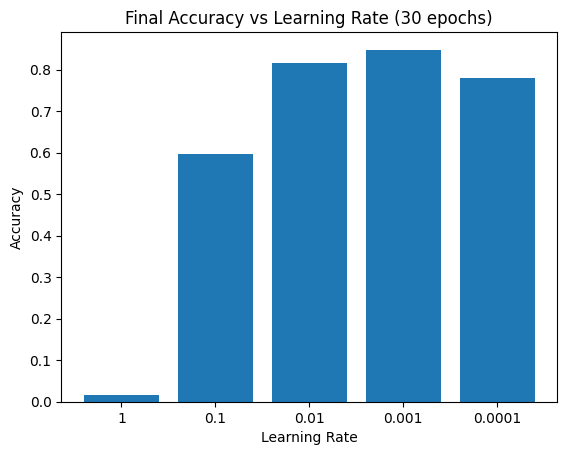

In [276]:
learning_rates = [1, 0.1, 0.01, 0.001, 0.0001]
final_accuracies = []
train_loader, test_loader = get_loaders()

for lr in learning_rates:
    test_cnn = CNN(num_classes).to(device)
    test_cnn_criterion = nn.CrossEntropyLoss()
    test_cnn_optimizer = torch.optim.Adam(test_cnn.parameters(), lr=lr)
    _ = train(test_cnn, train_loader, test_loader, test_cnn_criterion, test_cnn_optimizer, num_epochs=30, print_every=29)
    final_accuracies.append(evaluate(test_cnn, test_loader, test_cnn_criterion, True)[1])

# plot the epochs
plt.bar([str(lr) for lr in learning_rates], final_accuracies)
plt.title("Final Accuracy vs Learning Rate (30 epochs)")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.show()
    